# Road Segmentation on CREODIAS CDSE Sentinel 2 imagery

The model is trained for the task of segmentation on RGB satellite imagery

In [13]:
import rasterio as rio

img_path = 'samples/T33TYE_20250108T094309_TCI_10m.jp2' 

ds = rio.open(img_path)
x = ds.read()

x.shape, x.dtype, x.min(), x.max()

((3, 10980, 10980), dtype('uint8'), 0, 255)

Looks like the image is already in RGB format, with 3 bands and `uint8` values between 0 and 255.

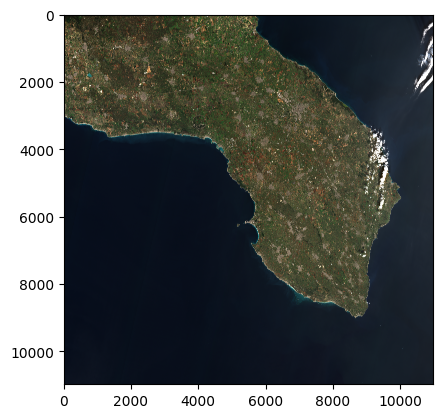

In [25]:
import matplotlib.pyplot as plt

_img = x.transpose(1,2,0)
plt.imshow(_img)

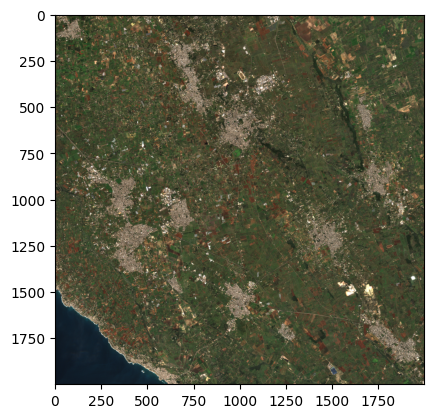

In [84]:
import matplotlib.pyplot as plt

img = _img[6000:8000, 6000:8000]
plt.imshow(img)

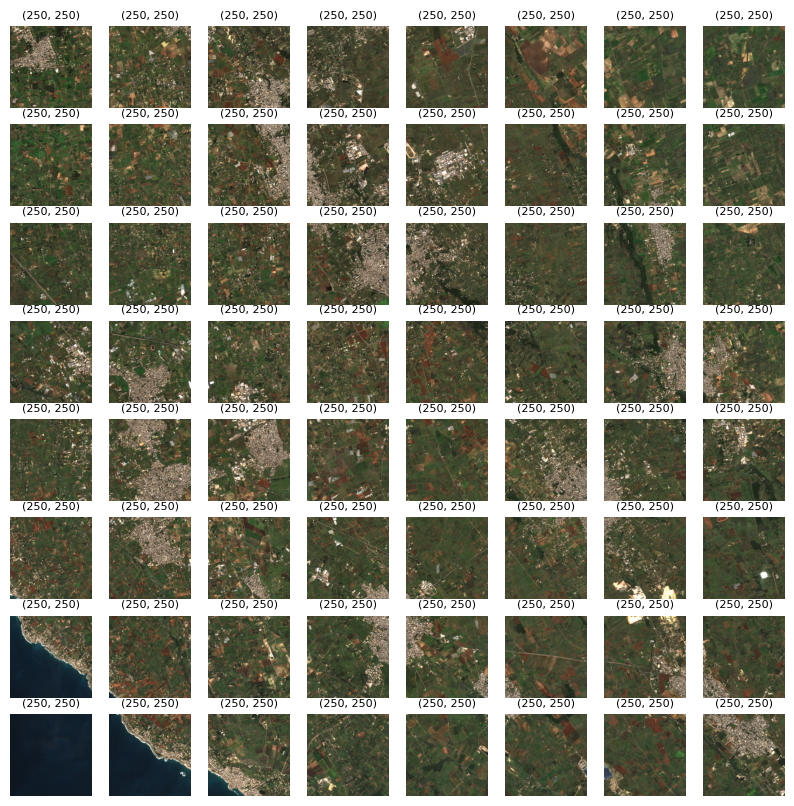

In [85]:
import numpy as np

# split the image into 16x16 non-overlapping patches
N = 8
img_array = np.array(img)
patches_h = np.array_split(img_array, N, axis=0)  # split horizontally first
patches = []
for patch in patches_h:
    patches.extend(np.array_split(patch, N, axis=1))  # split each half vertically

# plot
fig = plt.figure(figsize=(10,10))
for i, patch in enumerate(patches):
    ax = fig.add_subplot(N,N,i+1)
    ax.imshow(patch)
    ax.axis('off')
    ax.set_title(patch.shape[:2], fontsize=8)
plt.show()

Model metadata

In [86]:
import requests
from IPython.display import JSON
import json

url = f'http://localhost:8000/RoadSegmentationQ2'
# url  = f'https://eotdl.dev.gda.adamplatform.eu/RoadSegmentationQ2'

res = requests.get(url)

with open('metadata.json', 'w') as f:
    json.dump(json.loads(res.json()), f, indent=2)

!cat metadata.json

{
  "type": "FeatureCollection",
  "features": [
    {
      "id": "0",
      "type": "Feature",
      "properties": {
        "type": "Catalog",
        "id": "RoadSegmentationQ2",
        "stac_version": "1.0.0",
        "description": "Catalog for the Road Segmentation Q2 ML Model",
        "links": [
          {
            "rel": "self",
            "href": "/tmp/RoadSegmentationQ2/v1/RoadSegmentationQ2/catalog.json",
            "type": "application/json"
          },
          {
            "rel": "root",
            "href": "./catalog.json",
            "type": "application/json"
          },
          {
            "rel": "child",
            "href": "./model/collection.json",
            "type": "application/json"
          }
        ],
        "extent": null,
        "license": null,
        "properties": null,
        "assets": null,
        "bbox": null,
        "stac_extensions": null,
        "collection": null
      },
      "geometry": null
    },
    {
      "id": "1"

Perform inference on one patch

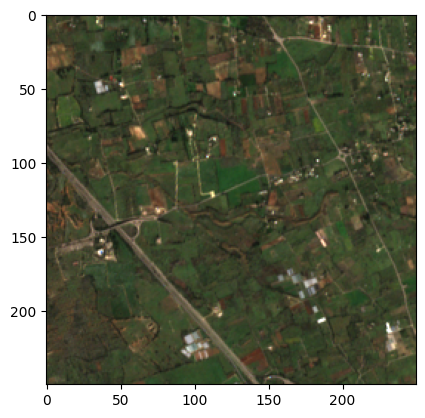

In [92]:
plt.imshow(patches[16])

In [93]:
import aiohttp
from PIL import Image
import io
import requests

patch_img = Image.fromarray(patches[16].astype('uint8'))
img_byte_arr = io.BytesIO()
patch_img.save(img_byte_arr, format='PNG')
img_byte_arr.seek(0)

res = requests.post(url, files={'image': img_byte_arr})

if res.status_code != 200:
   print(res.json())

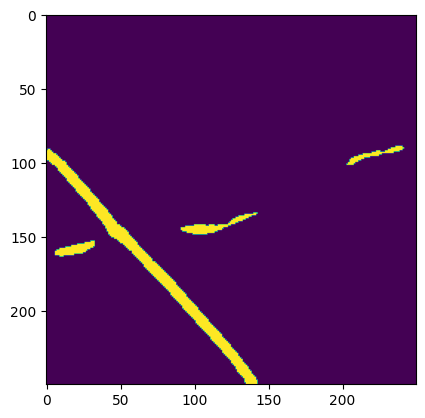

In [94]:
import numpy as np
import io 
from PIL import Image
import numpy as np 

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

image_bytes = io.BytesIO(res.content)
img = Image.open(image_bytes)

logits = np.array(img) 
probas = sigmoid(logits)
mask = probas > 0.5 # use different thresholds for sensitivity analysis
# mask = img

# plt.imshow(array)
plt.imshow(mask)

# mask.shape, mask.dtype, mask.min(), mask.max()

Generate a mask for the entire image

In [90]:
import asyncio

async def send_request(session, patch):
    # Convert patch to PIL Image and save to bytes buffer
    patch_img = Image.fromarray(patch.astype('uint8'))
    img_byte_arr = io.BytesIO()
    patch_img.save(img_byte_arr, format='PNG')
    img_byte_arr.seek(0)
    
    data = aiohttp.FormData()
    data.add_field('image', img_byte_arr, filename='patch.png')
    
    async with session.post(url, data=data) as response:
        content = await response.read()
        image_bytes = io.BytesIO(content)
        img = Image.open(image_bytes)
        return np.array(img)

async def process_patches():
    async with aiohttp.ClientSession() as session:
        tasks = []
        for patch in patches:  # patches was created earlier by splitting the image
            tasks.append(send_request(session, patch))
        
        results = await asyncio.gather(*tasks)
        return results

# For Jupyter notebook, use this instead of asyncio.run():
patch_results = await process_patches()

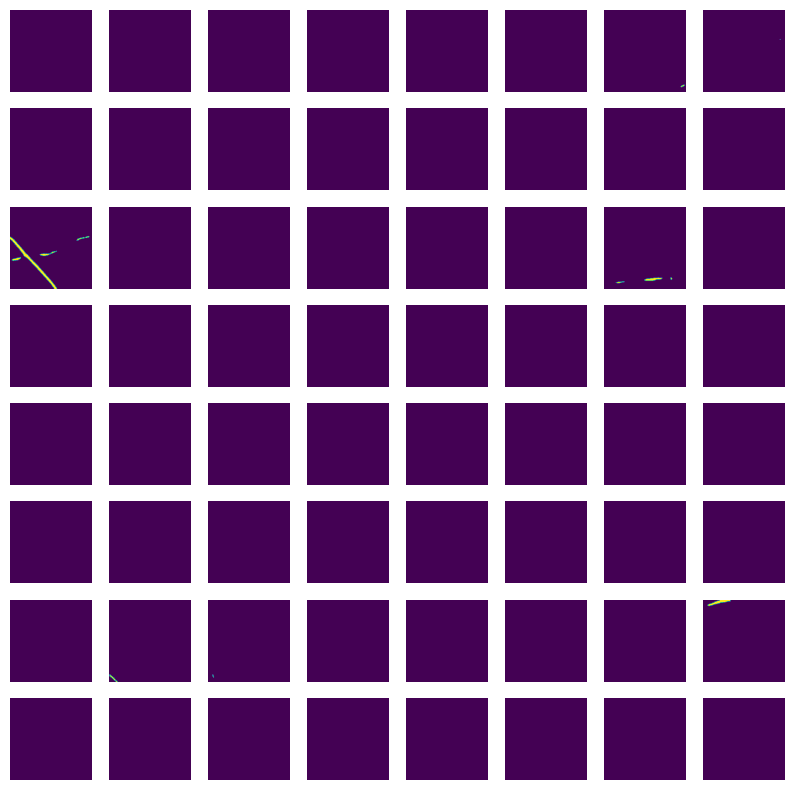

In [95]:
# Process and display results 
fig, axes = plt.subplots(N, N, figsize=(10, 10))
for i, logits in enumerate(patch_results):
    row = i // N
    col = i % N
    probas = sigmoid(logits)
    mask = probas > 0.5
    axes[row, col].imshow(mask)
    axes[row, col].axis('off')
plt.show()